In [1]:
# import the necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from scipy.sparse import csr_matrix
import scanpy as sc
import anndata

sc.set_figure_params(dpi=100, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/zebrafish.h5ad'

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.19.0 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.1


In [2]:
# read the raw csv data

X = sc.read_csv("../datasets/data.csv")

Convert the data into a form that `scanpy` can use

In [3]:
adata = anndata.AnnData(X=X)

In [4]:
# create checkpoints
adata.write(results_file)

In [5]:
adata = sc.read(results_file)

I mostly followed https://nbisweden.github.io/excelerate-scRNAseq/session-trajectories/trajectory_inference_analysis.pdf Slide#2 from here on

Perform pre-processing -- normalization, filtering etc.
https://scanpy.readthedocs.io/en/latest/api/scanpy.pp.recipe_seurat.html#scanpy.pp.recipe_seurat

In [6]:
sc.pp.recipe_seurat(adata)

filtered out 17514 cells that have less than 200 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)


In [7]:
# perform PCA
print('Calculating PCA...')
sc.tl.pca(adata, svd_solver='arpack')

Calculating PCA...
computing PCA
    with n_comps=50
    finished (0:00:01)


In [8]:
# this procedure relies on UMAP
# essentially perform UMAP om the dimensionally-reduced data
print('Calculating neighbour graph...')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=15)

Calculating neighbour graph...
computing neighbors
    using 'X_pca' with n_pcs = 15


/Users/reang/anaconda3/envs/compbio/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


In [9]:
# perform clustering using the leiden/louvain algorithm
# this gave 13 clusters
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


### Plot the clustered data before performing PAGA

In [10]:
sc.tl.draw_graph(adata, color='leiden')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:10)


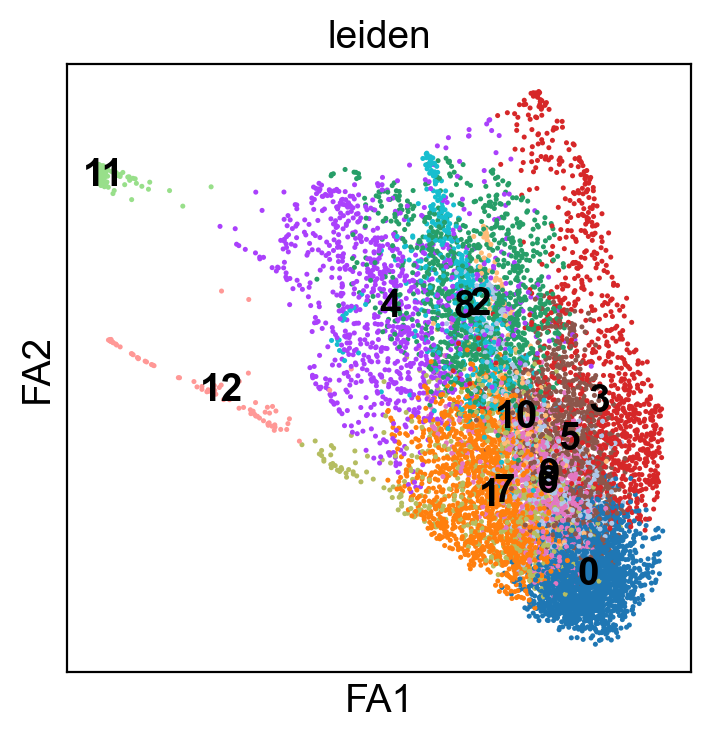

In [11]:
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

In [12]:
# this gives generic cluster names like 1, 2, so on.
# would be much more useful if I knew the cluster names
adata.obs['clusters'] = adata.obs['leiden']
adata.rename_categories('clusters', [str(i) for i in range(len(adata.obs['clusters'].cat.categories))])

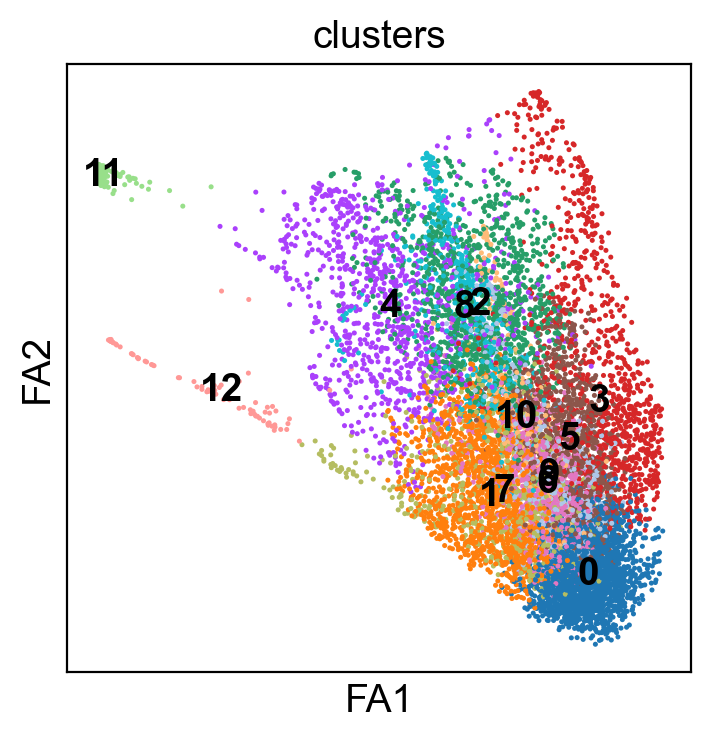

In [13]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

In [14]:
adata.obs['clusters'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

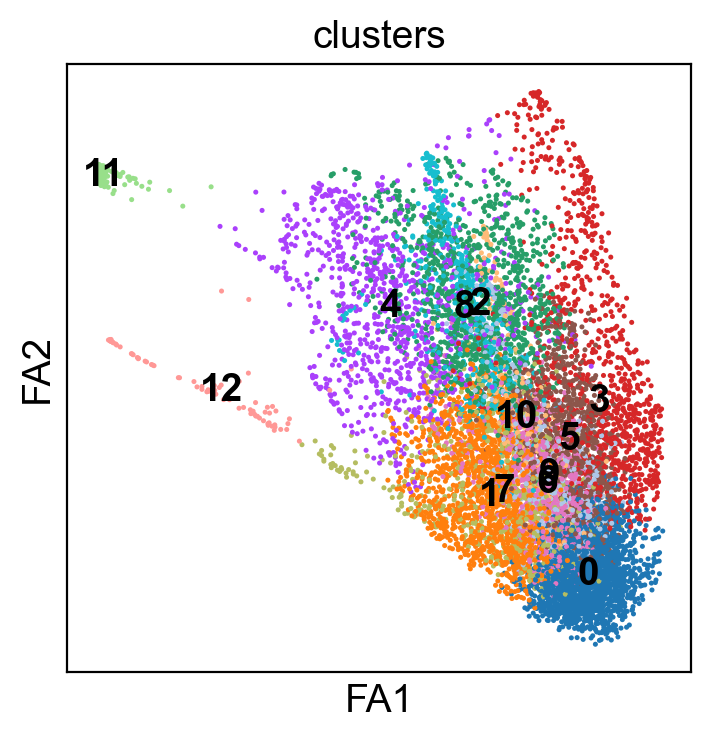

In [15]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

### Perform PAGA on the processed data

In [16]:
print('Performing PAGA...')
sc.tl.paga(adata, groups='clusters')

Performing PAGA...
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


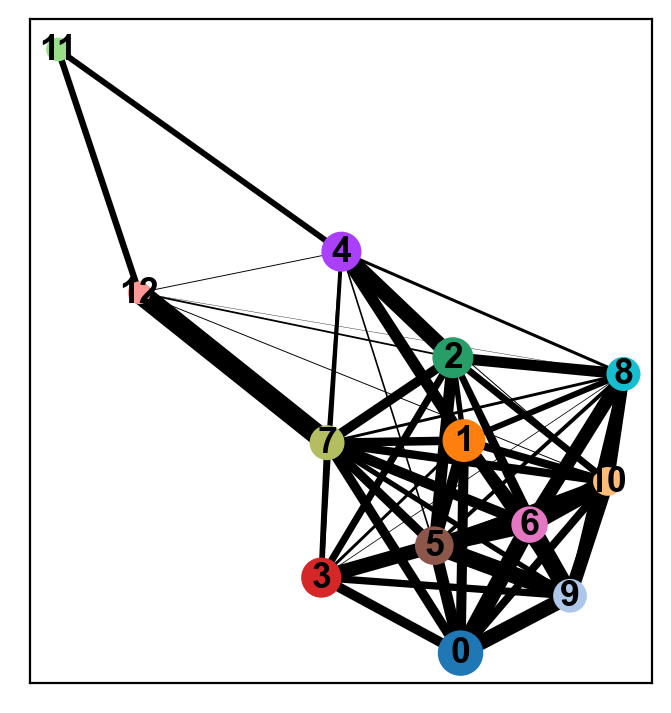

In [17]:
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


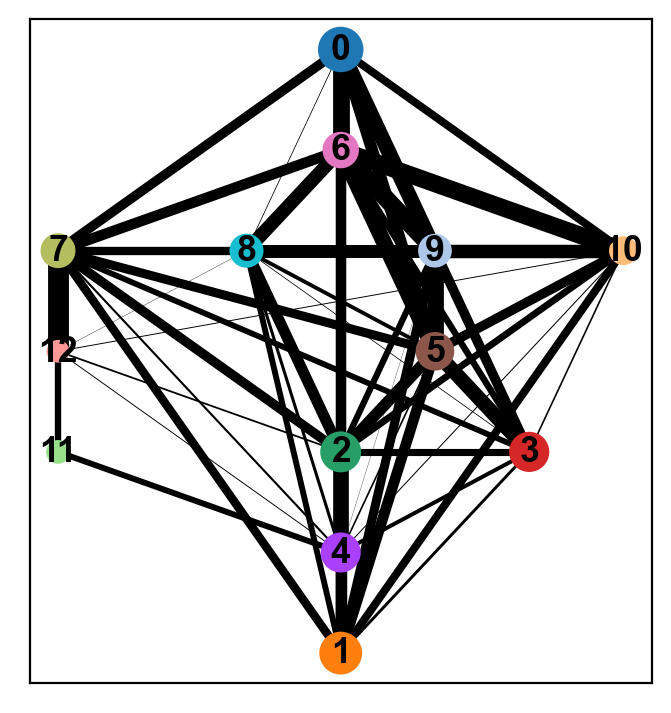

In [18]:
# just playing around, the root of the graph can be changed to any one
# or multiple nodes
sc.pl.paga(adata, layout='rt', root=[0])